In [2]:
import pyodbc
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score, mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv('C:/Users/tcardenas/OneDrive/OneDrive - Grupo DISPAPELES/Documents/ML-Dispapeles-TomasCaLo/Clustering/Clustering 1-2-23.csv', delimiter= ";")
df = df[(df["Letra cluster"] == "A") | (df["Letra cluster"] == "B")]
df_10_ag = df[df["Distrito-Nombretipozona"] == '10-Artes graficas']

In [3]:
def df_cliente(nit_cliente, fecha_final):
    # Conexion al dwh
    cnxn = pyodbc.connect(
        driver='{SQL Server}',
        server='192.168.100.58',
        uid='bilectura',
        pwd='D1sp@p3l3s')
    cursor = cnxn.cursor()

    # Codigo SQL para cargar del dwh
    codigo_SQL = f"SELECT DATEFROMPARTS(VTAANO, VTAMES, 1) AS 'Fecha', SUM(VTAVLRVTA) AS 'Ventas' FROM V_VTA_VTAHEC WHERE CONCAT(CONCAT(VTANIT, '-'), VTASUC) = '{nit_cliente}' AND VTAFCH < '{fecha_final}' GROUP BY DATEFROMPARTS(VTAANO, VTAMES, 1)"

    #Cargue de la data desde el ERP de Dispapeles y se guarda en df
    cursor.execute(codigo_SQL)
    rows = cursor.fetchall()
    df_SQL = pd.DataFrame.from_records(rows, columns=[col[0] for col in cursor.description])
    df_SQL["Ventas"] = df_SQL["Ventas"].astype(int)
    df_SQL["Fecha"] = pd.to_datetime(df_SQL["Fecha"])
    df_SQL = df_SQL.set_index("Fecha")

    return df_SQL

In [15]:
def entrenar_arima(p, d, q, data, order_by):

    dict = []

    #definicion de cantidad de parametros del modelo ARIMA
    param_grid = [(p_p, d_d, q_q) for p_p in range(p) for d_d in range(d) for q_q in range(q)]

    print(f"Se van a correr {len(param_grid)} configuraciones del tipo {p, d, q}")

    for n, param in enumerate(param_grid):
        try:
            n_train = int(round(data.shape[0] * 0.8, 0))
        
            # Split data into training and testing sets
            train = data[:n_train]
            test = data[n_train:]

            model = ARIMA(train, order= param_grid[n])
            model_fit = model.fit()
        
            # make predictions
            predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

            # Evaluate the performance of the model using metrics such as mean absolute error (MAE) and mean squared error (MSE)
            mae = mean_absolute_error(test, predictions)
            mse = mean_squared_error(test, predictions)
            r2 = r2_score(test, predictions)
            mape = mean_absolute_percentage_error(test, predictions)

            dict.append({
                        "param": param_grid[n],
                        "mae": mae,
                        "mse": mse,
                        "r2": r2,
                        "mape": mape
                        })

        except:
            continue
    
    # Tabla de resultados de mejor modelo
    results = pd.DataFrame(dict).sort_values(order_by)
    best_param = results.iloc[0,0]

    # Fit del mejor modelo
    model_best = ARIMA(train, order= best_param)
    model_fit_best = model_best.fit()

    # make predictions
    predictions_best = model_fit_best.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
    predictions_best = pd.DataFrame(predictions_best)

    # Mensaje de salida
    print(f'La mejor configuracion es {best_param} con un mape de {results.iloc[0,4]}')

    return results, best_param, predictions_best


In [17]:
def plot_best_model(data_orig, data_pred):
    
    n_train = int(round(data_orig.shape[0] * 0.8, 0))
        
    # Split data into training and testing sets
    train = data_orig[:n_train]
    test = data_orig[n_train:]

    
    fig, ax = plt.subplots(figsize=(12, 7))
    ax.plot(data_orig.values)
    ax.plot(np.arange(len(data_orig) - len(test), len(data_orig)), data_pred.values)
    # ax.plot(predictions_best.values)
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Ventas')
    fig.autofmt_xdate()
    plt.tight_layout()

In [ ]:
# nit_cliente = "'800226417-1'"
# nit_cliente = "'900085929-1'"
nit_cliente = "'900173543-1'"
# nit_cliente = "'800065396-1'"
fecha_final = "'2023-01-31'"

In [20]:
df_SQL = df_cliente(nit_cliente= "900085929-1", fecha_final= "2023-01-31")

In [21]:
results, best_param, predictions_best = entrenar_arima(p= 5, d= 2, q= 5, data= df_SQL, order_by= 'mape')

Se van a correr 50 configuraciones del tipo (5, 2, 5)
La mejor configuracion es (2, 1, 2) con un mape de 0.4549004425730532


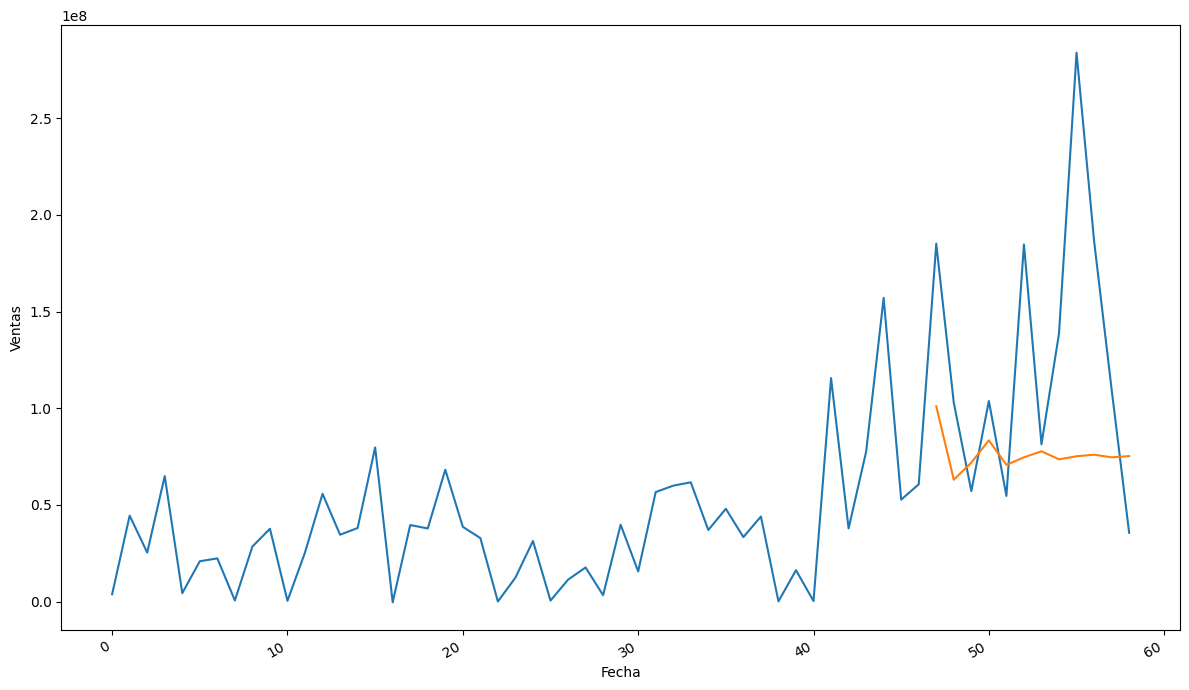

In [22]:
plot_best_model(df_SQL, predictions_best)